In [2]:
from pyspark.sql import SparkSession
import os
from pyspark.sql.types import ArrayType, FloatType, IntegerType, StringType, StructType, StructField
from pyspark.sql.functions import concat, lit
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix

In [3]:
spark: SparkSession = SparkSession.builder.appName("Traffic Signs Classification") \
  .master("local[*]") \
  .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
  .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
  .config("spark.rapids.sql.enabled", "true") \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g") \
  .config("spark.python.worker.memory", "12g") \
  .config("spark.executor.pyspark.memory", "12g") \
  .config("spark.rpc.message.maxSize", "128") \
  .config("spark.executor.memoryOverhead", "2g") \
  .config("spark.executor.heartbeatInterval", "30s") \
  .config("spark.network.timeout", "300s") \
  .config("spark.sql.adaptive.enabled", "true") \
  .config("spark.memory.fraction", "0.6") \
  .config("spark.driver.maxResultSize", "2g") \
  .config("spark.sql.shuffle.partitions", "20") \
  .config("spark.default.parallelism", "20") \
  .config("spark.sql.streaming.checkpointLocation", "./tmp") \
  .getOrCreate()
  
spark.sparkContext.setLogLevel("ERROR")
  
  # .config('spark.driver.extraClassPath', 'rapids-4-spark_2.13-24.10.1.jar') \
  # .config('spark.executor.extraClassPath', 'rapids-4-spark_2.13-24.10.1.jar') \
  # .config("spark.plugins", "com.nvidia.spark.rapids.GpuPlugin") \
  # .config("spark.sql.extensions", "com.nvidia.spark.rapids.SQLExecPlugin") \
  # .config("spark.executor.resource.gpu.amount", "1") \
  
  
  #   .master("local[*]") \
  # .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
  # .config("spark.local.dir", "/mnt/e/spark-temp") \
  # .config("spark.eventLog.dir", "/mnt/e/spark-event-logs") \
  
  
  # .master("local[*]") \
  # 
  # .config("spark.executor.extraJavaOptions", "-XX:+PrintGCDetails -XX:+PrintGCDateStamps -Xloggc:tmp/gc.log") \
  # .config("spark.sql.execution.arrow.pyspark.enabled", "false") \


your 131072x1 screen size is bogus. expect trouble
24/12/24 03:02:47 WARN Utils: Your hostname, DESKTOP-SMHNFU4 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/24 03:02:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/24 03:02:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
dataset_path = './dataset'

if not os.path.exists(dataset_path):
  raise BaseException("Path not found")

schema = StructType([
    StructField("Width", IntegerType(), True),
    StructField("Height", IntegerType(), True),
    StructField("Roi.X1", IntegerType(), True),
    StructField("Roi.Y1", IntegerType(), True),
    StructField("Roi.X2", IntegerType(), True),
    StructField("Roi.Y2", IntegerType(), True),
    StructField("ClassId", IntegerType(), True),
    StructField("Path", StringType(), True)
])

train_data_df = spark.read.csv(os.path.join(dataset_path, 'Train.csv'), schema=schema, header=True)
train_data_df = train_data_df.withColumn("Path", concat(lit(dataset_path + "/"), train_data_df["Path"])).dropna(subset=["ClassId"])
train_data_df.show()

+-----+------+------+------+------+------+-------+--------------------+
|Width|Height|Roi.X1|Roi.Y1|Roi.X2|Roi.Y2|ClassId|                Path|
+-----+------+------+------+------+------+-------+--------------------+
|   27|    26|     5|     5|    22|    20|     20|./dataset/Train/2...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|
|   29|    26|     6|     5|    24|    21|     20|./dataset/Train/2...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|
|   28|    26|     5|     5|    23|    21|     20|./dataset/Train/2...|
|   31|    27|     6|     5|    26|    22|     20|./dataset/Train/2...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...|
|   31|    29|     5|     6|    26|    24|     20|./dataset/Train/2...|
|   34|    32|     6|     6|    29|    26|     20|./dataset/Train/2...|
|   36|    33|     5|     6|    31|    28|     20|./dataset/Trai

In [5]:
class_labels = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of Speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No overtaking",
    10: "No overtaking for trucks",
    11: "Priority at next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no overtaking",
    42: "End of no overtaking for trucks"
}


In [8]:
def process_image(img_path, roi_x1, roi_y1, roi_x2, roi_y2):
    try:
        img = Image.open(img_path)
        cropped_img = img.crop((roi_x1, roi_y1, roi_x2, roi_y2))
        resized_img = np.array(cropped_img.resize((32, 32), resample=Image.Resampling.LANCZOS))
        return (resized_img.flatten() / 255.0).tolist()
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return [0.0] * (32 * 32 * 3)

def image_to_vector(img_features):
    return Vectors.dense(img_features)

image_to_vector_udf = udf(image_to_vector, VectorUDT())

spark.udf.register("process_image", process_image, ArrayType(FloatType()))
spark.udf.register("image_to_vector", image_to_vector, VectorUDT())

image_transformer = SQLTransformer(statement='SELECT *, image_to_vector(process_image(Path, `Roi.X1`, `Roi.Y1`, `Roi.X2`, `Roi.Y2`)) features FROM __THIS__')

processed_df = image_transformer.transform(train_data_df)

processed_df.show()


Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888



+-----+------+------+------+------+------+-------+--------------------+--------------------+
|Width|Height|Roi.X1|Roi.Y1|Roi.X2|Roi.Y2|ClassId|                Path|            features|
+-----+------+------+------+------+------+-------+--------------------+--------------------+
|   27|    26|     5|     5|    22|    20|     20|./dataset/Train/2...|[0.2,0.1960784313...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|[0.19215686274509...|
|   29|    26|     6|     5|    24|    21|     20|./dataset/Train/2...|[0.19607843137254...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|[0.19215686274509...|
|   28|    26|     5|     5|    23|    21|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    27|     6|     5|    26|    22|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...

In [9]:
processed_df.write.mode("overwrite").parquet("processed_df")

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888



In [10]:
processed_df = spark.read.parquet("processed_df")
processed_df.show()

+-----+------+------+------+------+------+-------+--------------------+--------------------+
|Width|Height|Roi.X1|Roi.Y1|Roi.X2|Roi.Y2|ClassId|                Path|            features|
+-----+------+------+------+------+------+-------+--------------------+--------------------+
|   27|    26|     5|     5|    22|    20|     20|./dataset/Train/2...|[0.2,0.1960784313...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|[0.19215686274509...|
|   29|    26|     6|     5|    24|    21|     20|./dataset/Train/2...|[0.19607843137254...|
|   28|    27|     5|     6|    23|    22|     20|./dataset/Train/2...|[0.19215686274509...|
|   28|    26|     5|     5|    23|    21|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    27|     6|     5|    26|    22|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...|[0.18823529411764...|
|   31|    28|     6|     6|    26|    23|     20|./dataset/Train/2...

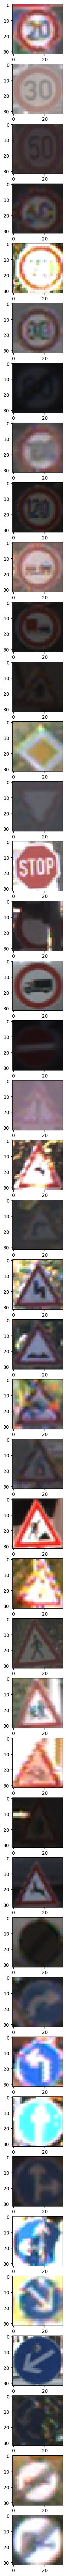

In [8]:
fig, ax = plt.subplots(len(class_labels), figsize=(10, 100))

for key in class_labels:
  img = processed_df.filter(processed_df.ClassId == key).limit(1).toPandas()

  reshaped_image = img.iloc[0].features.reshape(32, 32, 3)
  ax[key].imshow(reshaped_image)
  
plt.show()

In [30]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import numpy as np

pca = PCA(k=2, inputCol="features", outputCol="pca_features")

pca_model = pca.fit(processed_df)
pca_data = pca_model.transform(processed_df)

pca_points = pca_data.select("pca_features", "ClassId").rdd.map(
    lambda row: (row["pca_features"][0], row["pca_features"][1], row["ClassId"])
).collect()

x = [point[0] for point in pca_points]
y = [point[1] for point in pca_points]
labels = [point[2] for point in pca_points]



Current mem limits: -1 of max -1                                                

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of m

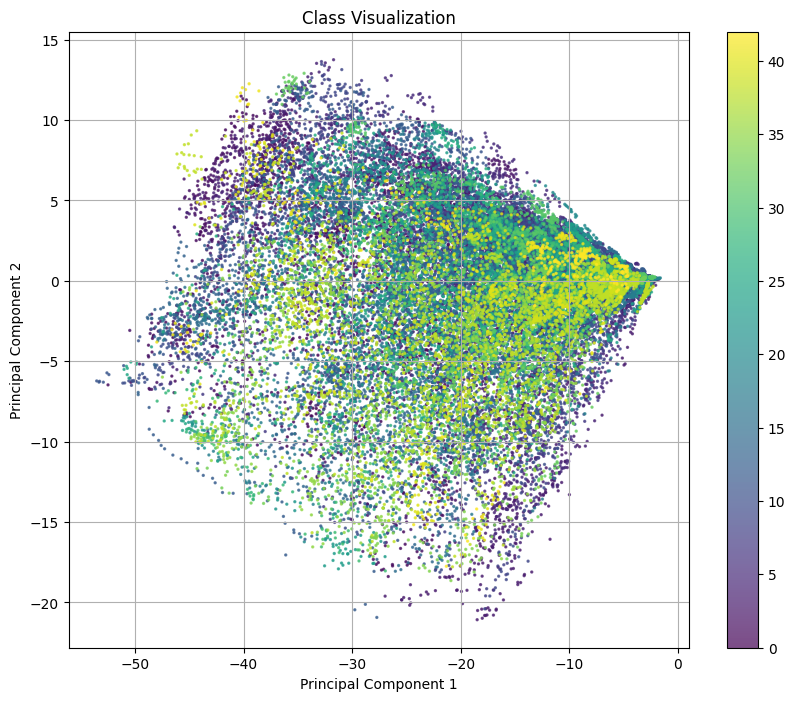

In [33]:
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=labels, alpha=0.7, s=2)
plt.colorbar()
plt.title(f"Class Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

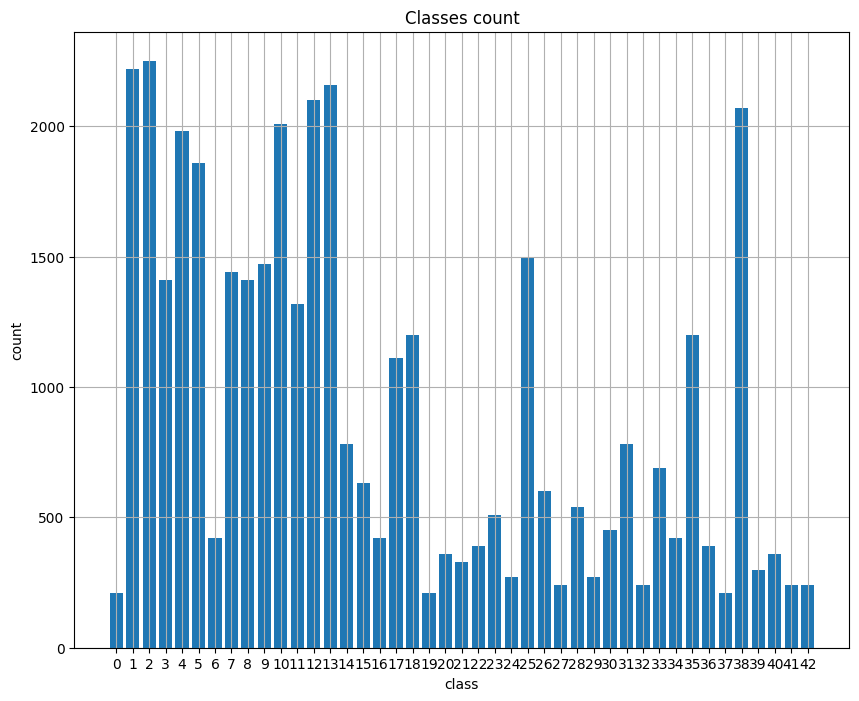

In [27]:
count_data = processed_df.groupBy("ClassId").count().toPandas()

plt.figure(figsize=(10, 8))
plt.bar(count_data["ClassId"], count_data["count"])
plt.title(f"Classes count")
plt.xticks(count_data["ClassId"])
plt.xlabel("class")
plt.ylabel("count")
plt.grid(True)
plt.show()

In [11]:
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="ClassId", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="ClassId", predictionCol="prediction", metricName="f1")

Logistic regression

In [8]:
lr = LogisticRegression(featuresCol="features", labelCol="ClassId", maxIter=80)
pipeline = Pipeline(stages=[image_transformer, lr])

paramGrid_lr = ParamGridBuilder() \
  .addGrid(lr.regParam, [1e-4, 1e-3, 0.01]) \
  .addGrid(lr.tol, [0, 0.5]) \
  .addGrid(lr.elasticNetParam, [1e-3, 0.01, 0.1]) \
  .build()


cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid_lr, evaluator=evaluator_accuracy, numFolds=5, seed=1234)

model = cv.fit(train_data_df)

bestModel = model.bestModel
bestModel.write().overwrite().save("best-model-lr")

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: 12884901888 of max 12884901888                              

Current mem limits: -1 of max -1                                                

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: 12884901888 of max 12884901888                              

Current mem limits: 12884901888 of max 12884901888                              

Current mem limits: -1 of max -1                                                

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: 12884901888 of max 12884901888                              

Current mem limits: 12884901888 of max 12884901888                              

Current mem limits: -1 of max -1                                                

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: 12884901888 of max 12884901888                              

Current mem 

In [12]:
def show_confusion_matrix(predictions):
    predictions_pd = predictions.toPandas()

    conf_matrix = confusion_matrix(predictions_pd['ClassId'], predictions_pd['prediction'])

    fig, ax = plt.subplots(figsize=(30, 8))
    cax = ax.matshow(conf_matrix, cmap="Blues")

    plt.colorbar(cax)

    ax.set_xticks(range(len(class_labels)))
    ax.set_yticks(range(len(class_labels)))
    ax.set_xticklabels(class_labels, fontsize=7)
    ax.set_yticklabels(class_labels, fontsize=7)

    plt.title("Confusion Matrix", pad=20)
    plt.xlabel("Predicted", labelpad=10)
    plt.ylabel("Actual", labelpad=10)

    for (i, j), value in np.ndenumerate(conf_matrix):
        ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=7)

    plt.tight_layout()
    plt.show()

In [16]:
bestModel = PipelineModel.load("best-model-lr")
print("Best lr params:")
print(f"regParam={bestModel.stages[-1].getRegParam()} tol={bestModel.stages[-1].getTol()} elasticNetParam={bestModel.stages[-1].getElasticNetParam()}")

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888



Best lr params:
regParam=0.001 tol=0.0 elasticNetParam=0.01


In [10]:
test_metadata_df = spark.read.csv(os.path.join(dataset_path, 'Test.csv'), schema=schema, header=True)
test_metadata_df = test_metadata_df.withColumn("Path", concat(lit(dataset_path + "/"), test_metadata_df["Path"]))

In [11]:
final_predictions = bestModel.transform(test_metadata_df)

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: 12884901888 of max 12884901888                              

Current mem limits: 12884901888 of max 12884901888                              



Final results:
Accuracy: 0.8592240696753761
F1: 0.8568527435061243


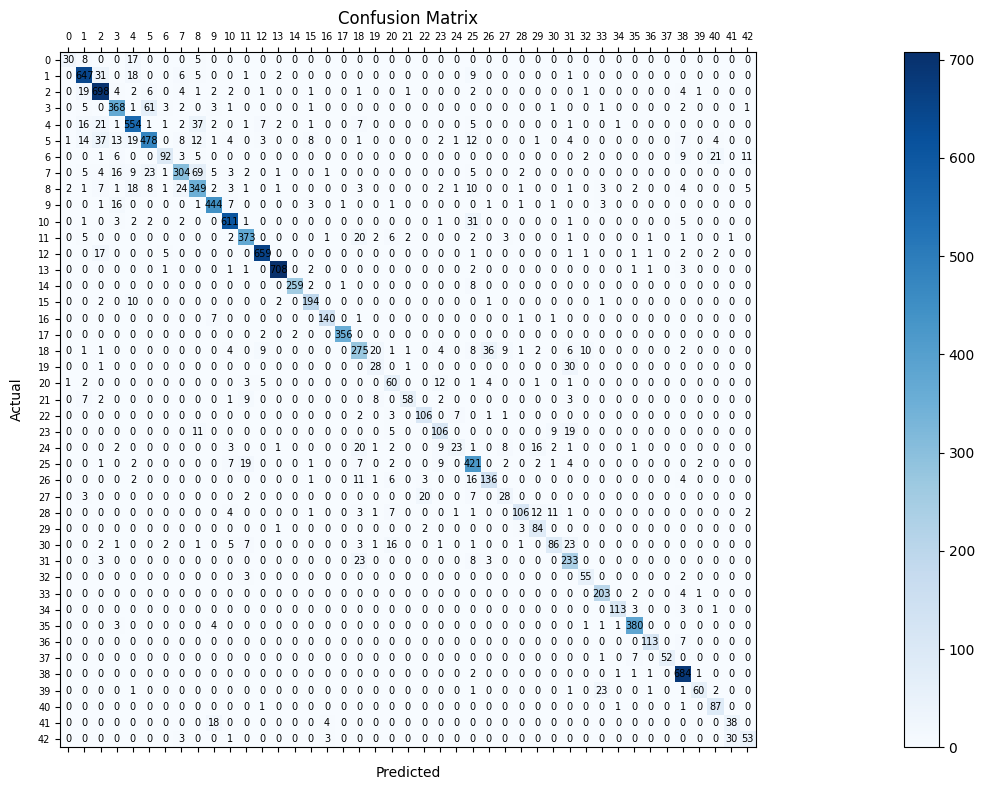

In [12]:
accuracy = evaluator_accuracy.evaluate(final_predictions)
f1 = evaluator_f1.evaluate(final_predictions)

print(f"Final results:")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")

show_confusion_matrix(final_predictions)

Random Forest

In [10]:
rf = RandomForestClassifier(featuresCol="features", labelCol="ClassId")
pipeline = Pipeline(stages=[image_transformer, rf])

paramGrid_rf = ParamGridBuilder() \
  .addGrid(rf.numTrees, [50, 100]) \
  .addGrid(rf.maxDepth, [17, 20, 22]) \
  .addGrid(rf.maxBins, [10, 12, 15]) \
  .build()

cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid_rf, evaluator=evaluator_accuracy, numFolds=5, seed=1234)

model = cv.fit(train_data_df)

bestModel = model.bestModel
bestModel.write().overwrite().save("best-model-rf")

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1                                                

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: 12884901888 of max 12884901888                              

Current mem limits: 12884901888 of max 12884901888                              

Current mem limits: -1 of max -1                                    (0 + 1) / 1]

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: 12884901888 of max 12884901888                              

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: 12884901888 of max 12884901888                              

Current mem limits: 12884901888 of max 12884901888                              

Current mem limits: -1 of max -1                                    (0 + 1) / 1]

Setting mem limits to 12884901888 of max 12884901888

Curren

In [22]:
bestModel = PipelineModel.load("best-model-rf")
print("Best rf params:")

print(f"numTrees={bestModel.stages[-1].getNumTrees} maxDepth={bestModel.stages[-1].getMaxDepth()} maxBins={bestModel.stages[-1].getMaxBins()}")

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888



Best rf params:
numTrees=100 maxDepth=20 maxBins=12


In [11]:
test_metadata_df = spark.read.csv(os.path.join(dataset_path, 'Test.csv'), schema=schema, header=True)
test_metadata_df = test_metadata_df.withColumn("Path", concat(lit(dataset_path + "/"), test_metadata_df["Path"]))

test_metadata_df.show()

+-----+------+------+------+------+------+-------+--------------------+
|Width|Height|Roi.X1|Roi.Y1|Roi.X2|Roi.Y2|ClassId|                Path|
+-----+------+------+------+------+------+-------+--------------------+
|   53|    54|     6|     5|    48|    49|     16|./dataset/Test/00...|
|   42|    45|     5|     5|    36|    40|      1|./dataset/Test/00...|
|   48|    52|     6|     6|    43|    47|     38|./dataset/Test/00...|
|   27|    29|     5|     5|    22|    24|     33|./dataset/Test/00...|
|   60|    57|     5|     5|    55|    52|     11|./dataset/Test/00...|
|   52|    56|     5|     5|    47|    51|     38|./dataset/Test/00...|
|  147|   130|    12|    12|   135|   119|     18|./dataset/Test/00...|
|   32|    33|     5|     5|    26|    28|     12|./dataset/Test/00...|
|   45|    50|     6|     5|    40|    45|     25|./dataset/Test/00...|
|   81|    86|     7|     7|    74|    79|     35|./dataset/Test/00...|
|   38|    37|     6|     5|    33|    32|     12|./dataset/Test

In [12]:
final_predictions = bestModel.transform(test_metadata_df)

Current mem limits: -1 of max -1                                    (0 + 1) / 1]

Setting mem limits to 12884901888 of max 12884901888



Current mem limits: 12884901888 of max 12884901888                  (0 + 1) / 1]



Final results:
Accuracy: 0.8188440221694379
F1: 0.8140109027014958


Current mem limits: 12884901888 of max 12884901888                  (0 + 1) / 1]



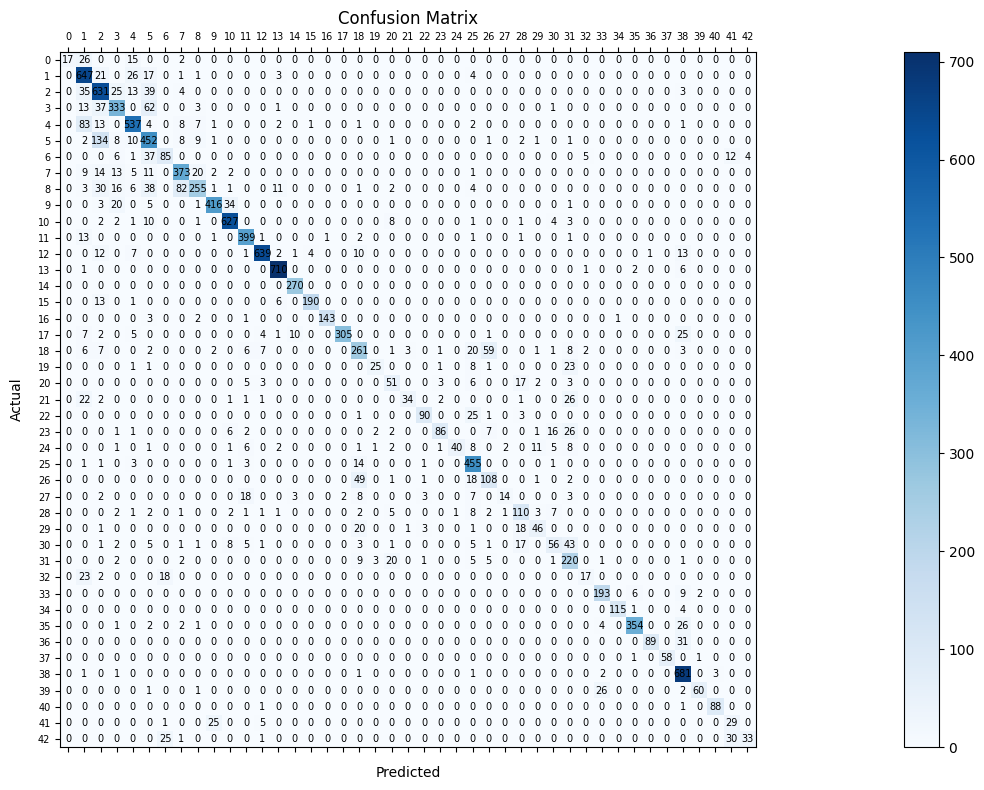

In [13]:
accuracy = evaluator_accuracy.evaluate(final_predictions)
f1 = evaluator_f1.evaluate(final_predictions)

print(f"Final results:")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")

show_confusion_matrix(final_predictions)

In [17]:
test_metadata_df = spark.readStream.csv(os.path.join(dataset_path, 'streaming'), schema=schema, header=True)
test_metadata_df = test_metadata_df.withColumn("Path", concat(lit(dataset_path + "/"), test_metadata_df["Path"]))

predictions_stream = bestModel.transform(test_metadata_df)

output_stream = predictions_stream.writeStream.outputMode("append").format("console").start()
output_stream.awaitTermination()

Current mem limits: -1 of max -1 1) / 1][Stage 4001:>               (0 + 4) / 4]

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888

Current mem limits: -1 of max -1

Setting mem limits to 12884901888 of max 12884901888



-------------------------------------------
Batch: 3
-------------------------------------------


+-----+------+------+------+------+------+-------+--------------------+--------------------+--------------------+--------------------+----------+
|Width|Height|Roi.X1|Roi.Y1|Roi.X2|Roi.Y2|ClassId|                Path|            features|       rawPrediction|         probability|prediction|
+-----+------+------+------+------+------+-------+--------------------+--------------------+--------------------+--------------------+----------+
|   53|    54|     6|     5|    48|    49|     16|./dataset/Test/00...|[0.47058823529411...|[0.0,0.0,2.0,1.0,...|[0.0,0.0,0.02,0.0...|      16.0|
|   42|    45|     5|     5|    36|    40|      1|./dataset/Test/00...|[0.34117647058823...|[2.00970873786407...|[0.02009708737864...|       1.0|
|   48|    52|     6|     6|    43|    47|     38|./dataset/Test/00...|[0.28627450980392...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|      38.0|
|   27|    29|     5|     5|    22|    24|     33|./dataset/Test/00...|[0.82352941176470...|[0.25,3.0,2.38333...|[0.00250000

-------------------------------------------
Batch: 0
-------------------------------------------
+-----+------+------+------+------+------+-------+--------------------+--------------------+--------------------+--------------------+----------+
|Width|Height|Roi.X1|Roi.Y1|Roi.X2|Roi.Y2|ClassId|                Path|            features|       rawPrediction|         probability|prediction|
+-----+------+------+------+------+------+-------+--------------------+--------------------+--------------------+--------------------+----------+
|   53|    54|     6|     5|    48|    49|     16|./dataset/Test/00...|[0.47058823529411...|[0.0,0.0,2.0,1.0,...|[0.0,0.0,0.02,0.0...|      16.0|
|   42|    45|     5|     5|    36|    40|      1|./dataset/Test/00...|[0.34117647058823...|[2.00970873786407...|[0.02009708737864...|       1.0|
|   48|    52|     6|     6|    43|    47|     38|./dataset/Test/00...|[0.28627450980392...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|      38.0|
|   27|    29|     5|     5

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 